## Cointegrated mean reversal backtesting using coingecko module

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pycoingecko import CoinGeckoAPI
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

In [31]:
cg = CoinGeckoAPI()


#### Fetch Price

In [77]:
def get_price_data(coin_id, vs_currency='usd', days='360'):
    data = cg.get_coin_market_chart_by_id(id=coin_id, vs_currency=vs_currency, days=days)
    prices = pd.DataFrame(data['prices'], columns=['timestamp', coin_id])
    prices['timestamp'] = pd.to_datetime(prices['timestamp'], unit='ms')
    return prices.set_index('timestamp')

In [78]:
btc = get_price_data('bitcoin')
eth = get_price_data('ethereum')
ltc = get_price_data('litecoin')

In [79]:
df = ltc.join(eth, how='inner')
df.columns = ['LTC', 'ETH']
df.dropna(inplace=True)

In [80]:
df['LTC-nret'] = df['LTC'].pct_change()
df['ETH-nret'] = df['ETH'].pct_change()
df.dropna(inplace=True)

#### Test cointegration

In [81]:
#X = df['LTC']
X = df['LTC']
Y = df['ETH']
X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
beta = model.params['LTC']
spread = Y - beta * df['LTC']

In [83]:
adf_result = adfuller(spread)
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")

ADF Statistic: -1.8162026704213505
p-value: 0.3724477039896045


In [84]:
spread_mean = spread.mean()
spread_std = spread.std()
zscore = (spread - spread_mean) / spread_std

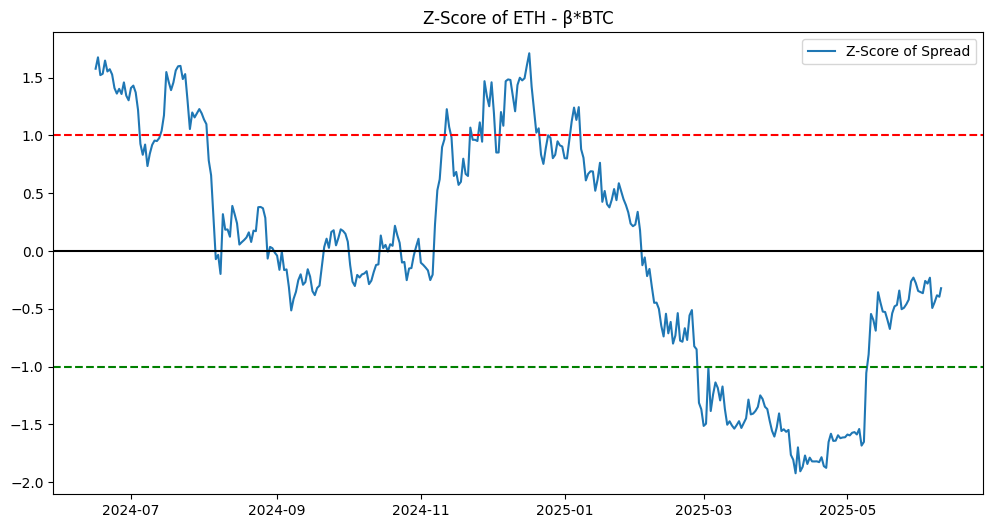

In [85]:
plt.figure(figsize=(12,6))
plt.plot(zscore, label='Z-Score of Spread')
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.title("Z-Score of ETH - β*BTC")
plt.legend()
plt.show()

In [57]:
signals = pd.DataFrame(index=zscore.index)
signals['zscore'] = zscore
signals['position'] = 0
signals.loc[zscore > 1, 'position'] = -1 
signals.loc[zscore < -1, 'position'] = 1 
signals['position'] = signals['position'].shift() 

In [58]:
spread_returns = spread.diff()
signals['pnl'] = signals['position'] * spread_returns

In [59]:
signals['cumulative_pnl'] = signals['pnl'].cumsum()


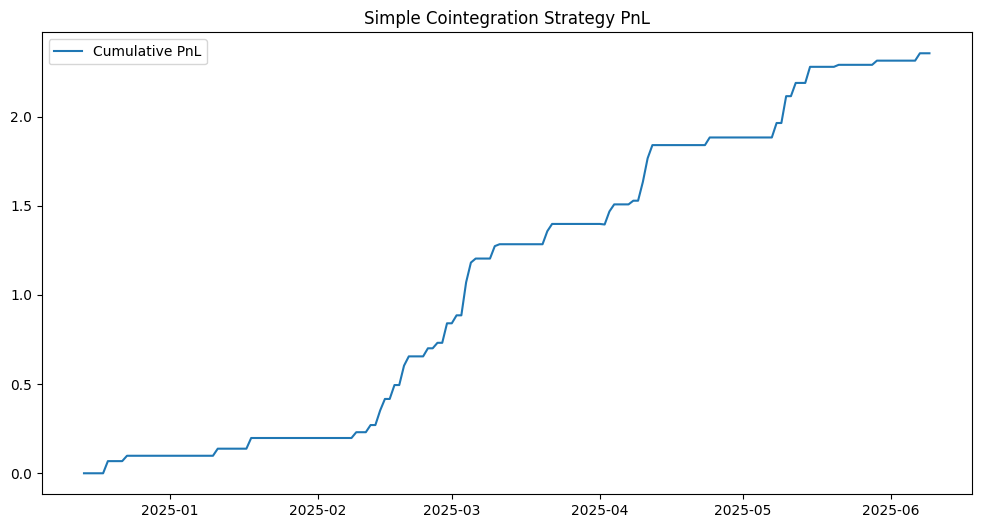

In [60]:
plt.figure(figsize=(12,6))
plt.plot(signals['cumulative_pnl'], label='Cumulative PnL')
plt.title("Simple Cointegration Strategy PnL")
plt.legend()
plt.show()

<Axes: xlabel='timestamp'>

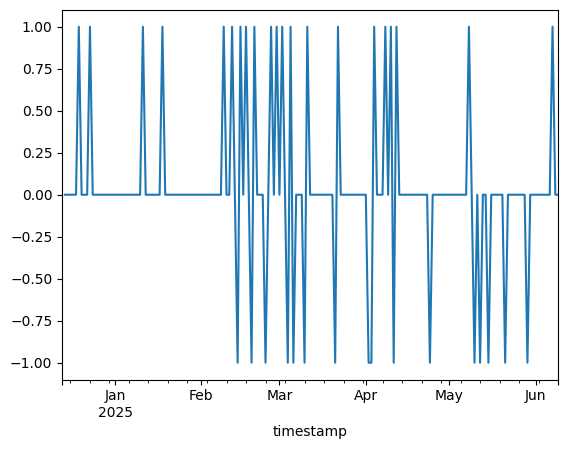

In [61]:
signals['position'].plot()